---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia Elétrica

ELE0611 - Tópicos especiais em controle analógico

Discente: Levy Gabriel

Título: Simulações em controle adaptativo robusto

---

# Inicialização

O trabalho desenvolvido se vale de um conjunto de bibliotecas básicas nativas da linguagem Python, mas também é apresentada um conjunto de funcionalidades desenvolvidas propriamente para a disciplina de controle adaptativo robusto. 

## Bibliotecas nativas

As bibliotecas nativas utilizadas são:

- Numpy para gerenciar operações matemáticas e algébricas complexas com facilidade;
- Matplotlib para apresentar os resultados graficamente;
- Time para calcular o tempo de execução das simulações.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image

## Classes desenvolvidas

As funcionalidades desenvolvidas nesse trabalho fazem o uso da programação orientada a objetos do Python para criar um esquema de simulação orientado a blocos. Permitindo assim que após a programação desses blocos básicos, o único esforço do usuário seja para instanciar os blocos corretos com parâmetros customizáveis e conectar-los corretamente.

### Block

A primeira classe desenvolvida é a *Block*, que consiste em um bloco genérico que inicializa vetores de entrada e saída padrão de um bloco. Dessa classe herdarão os demais blocos. Também é desenvolvida o método **work** que é comum para todos os blocos e que ela executa um ciclo de simulação daquele bloco, assim recebendo uma entrada (caso o bloco possua entradas), processando-a e gerando uma saída (caso o bloco possua saídas).

In [3]:
class Block:
    def __init__(self, 
                 name='Default', h=0.0001,
                 in_type=[np.float64, ],
                 out_type=[np.float64, ],
                 in_buff_len=0, out_buff_len=0
                 ):
        DefaultDtype = np.float64
        self.name = name             # name
        self.h = h                   # sampling time
        self.in_len = len(in_type)   # input buffer length
        self.out_len = len(out_type) # output buffer length

        self.in_buff_len = in_buff_len
        self.out_buff_len = out_buff_len

        # input and output buffer initialization 
        self.in_buffer = np.zeros((self.in_buff_len), dtype=DefaultDtype) # [actual, prev1, prev2...]
        self.out_buffer = np.zeros((self.out_buff_len), dtype=DefaultDtype) # [actual, prev1, prev2...]
    
    def data_in(self, in_data): pass
    def data_out(self): pass
    def data_processing(self): pass
    def work(self, in_data):
        self.data_in(in_data)
        return self.data_out()

### Source

Dando seguimento aos demais blocos, o próximo é o bloco *Source* que é responsável por gerar saídas com base em uma função **amplitude** definida na sua inicialização.

In [4]:
class Source(Block):
    def __init__(self, name='Source', h=0.0001,
                 amplitude= lambda t: 1):
        
        DefaultDtype = np.float64
        Block.__init__(self, name=name, h=h, in_type=[], out_type=[DefaultDtype,], in_buff_len=0, out_buff_len=1)
        self.count = 0
        self.amplitude = amplitude

    def data_out(self):
        self.out_buffer = self.amplitude(self.count*self.h)
        self.count += 1
        return self.out_buffer

    def work(self):
        return self.data_out()

### Sum

O bloco *Sum* é essencial para realizar operações de somas ou subrações ponderadas.

In [5]:
class Sum(Block):
    def __init__(self, name='Sum', 
                 ports_gains = (1, 1)):
        
        DefaultDtype = np.float64

        self.num_inputs = len(ports_gains)
        self.input_gains = np.array(ports_gains, dtype=DefaultDtype)

        in_type = []
        for i in range(self.num_inputs): in_type.append(DefaultDtype)
        Block.__init__(self, name=name, in_type=in_type, out_type=[DefaultDtype,], in_buff_len=self.num_inputs, out_buff_len=1)

    def data_in(self, in_data):
        self.in_buffer = np.array(in_data, dtype=np.float64)

    def data_out(self):
        self.out_buffer = self.data_processing()
        return self.out_buffer

    def data_processing(self):
        DefaultDtype = np.float64
        acc = DefaultDtype(0)
        for i in range(self.num_inputs):
          acc += self.input_gains[i]*self.in_buffer[i]
        return acc
    

### Multiply

O bloco *Multiply* possui estrutura semelhante ao bloco *Sum*, com a diferença que todas as suas entradas são multiplicadas entre si.

In [6]:
class Multiply(Block):
    def __init__(self, name='Multiply', 
                 number_inputs = 2):
        
        DefaultDtype = np.float64

        self.num_inputs = number_inputs

        in_type = []
        for i in range(self.num_inputs): in_type.append(DefaultDtype)
        Block.__init__(self, name=name, in_type=in_type, out_type=[DefaultDtype,], in_buff_len=self.num_inputs, out_buff_len=1)

    def data_in(self, in_data):
        self.in_buffer = np.array(in_data, dtype=np.float64)

    def data_out(self):
        self.out_buffer = self.data_processing()
        return self.out_buffer

    def data_processing(self):
        DefaultDtype = np.float64
        acc = DefaultDtype(1)
        for i in range(self.num_inputs):
          acc *= self.in_buffer[i]
        return acc

### TF

O bloco *TF* é um dos blocos mais importantes deste trabalho. Ele implementa uma função de transferência causal genérica e processa as entradas de acordo com o numerador e denominador da função de transferência com base no método da aproximação para trás de Euler.

In [7]:
class TF(Block):
    def __init__(self, name='Transfer function', h=0.0001,
                 initial_conditions = [],
                 numerator = [], 
                 denominator= []):
        
        DefaultDtype = np.float64

        self.len_num = len(numerator)
        self.len_den = len(denominator)

        Block.__init__(self, name=name, h=h, in_type=[DefaultDtype,], out_type=[DefaultDtype,], in_buff_len=self.len_num, out_buff_len=self.len_den)
  
        self.num = np.array(numerator, dtype=DefaultDtype) # s^n*c_n + ... + s^0*c_0
        self.den = np.array(denominator, dtype=DefaultDtype) # s^n*c_n + ... + s^0*c_0

        if(not len(initial_conditions)==0): self.out_buffer[-1:0:-1] = np.array(initial_conditions, dtype=DefaultDtype) # D^ny(t), D^(n-1)y(t), ..., D^1y(t), D^0y(t)

    def data_in(self, in_data):
      self.in_buffer = np.roll(self.in_buffer,shift=1,axis=0)
      self.in_buffer[0] = in_data

    def data_out(self):
      out_data = self.out_buffer[-1]
      if(out_data>1000): return
      if(out_data<-1000): return
      self.out_buffer[0] = np.float64(0)
      self.out_buffer[0] = self.data_processing()
      self.out_buffer = np.roll(self.out_buffer,shift=1,axis=0)
      return out_data

    def get_out(self): return self.out_buffer[-1]
    
    def data_processing(self):
      num = np.flip(self.num) # s^0*c_0 + ... + s^n*c_n
      den = np.flip(self.den) # s^0*c_0 + ... + s^n*c_n
      x = np.flip(self.in_buffer) # [prev_n, prev_n-1, ... , prev_1, actual]
      y = np.flip(self.out_buffer) # [prev_n, prev_n-1, ... , prev_1, actual]
      accX = np.float64(0)
      accY = np.float64(0)
      accDen = np.float64(0)
      
      # input contribution
      for itr in range(self.len_num):
        accX += (num[itr]*x[-1]/(self.h**itr))
        x = np.diff(x)
      # output contribution
      for itr in range(self.len_den-1):
        y = np.diff(y)
        accY += (den[itr+1]*y[-1]/(self.h**(itr+1)))
      # actual output contribution
      for itr in range(self.len_den): 
        accDen += (den[itr]/(self.h**itr))

      return (accX-accY)/accDen

    def reset(self, initial_conditions = []):
        if(not len(initial_conditions)==0): self.out_buffer[-1:0:-1] = np.array(initial_conditions, dtype=np.float64) # D^ny(t), D^(n-1)y(t), ..., D^1y(t), D^0y(t)

### PID

O bloco *PID* representa um controaldor PID típico, porém este será utilizado apenas nas simulações iniciais do trabalho, uma vez que o controle adaptativo será o principal foco.

In [8]:
class PID(Block):
    def __init__(self, name='PID', h=0.0001, Kp=1, Ki=0, Kd=0):
        
        DefaultDtype = np.float64

        Block.__init__(self, name=name, h=h, in_type=[DefaultDtype,], out_type=[DefaultDtype,], in_buff_len=2, out_buff_len=1)
  
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral=DefaultDtype(0)

    def data_in(self, in_data):
      self.in_buffer = np.roll(self.in_buffer,shift=1,axis=0) # [error, lastError]
      self.in_buffer[0] = in_data

    def data_out(self):
      self.out_buffer = self.data_processing()
      return self.out_buffer

    def data_processing(self):
      error, lastError = self.in_buffer
      proportional = self.Kp*error
      self.integral = self.integral + proportional*self.h
      derivative = (proportional-lastError)/self.h
      return proportional + self.Ki*self.integral + self.Kd*derivative

### AdaptiveController

Esse sim será o controlador amplamente usado nesse trabalho na maior parte das simulações. A classe herda diretamente do bloco *Sum*, portanto ele não operará com fatores derivativos ou integrais, já que não possui memória. Na veredade ele implementa um controlador proporcional generalizado.

Vale destacar que este bloco possui um método *set_parameters*. Ele será bastante usado em conjunto com o bloco seguinte (*Estimator*).

In [9]:
class AdaptiveController(Sum):
    def __init__(self, name='AdaptiveController', 
                 ports_gains = [-1, 1]):
        
        DefaultDtype = np.float64

        truncated_gains = np.array(ports_gains, dtype=DefaultDtype)
        Sum.__init__(self, name=name, ports_gains=truncated_gains)


    def set_parameters(self, parameters = [-1,1]): self.input_gains = np.array(parameters, dtype=np.float64)
    def get_parameters(self): return self.input_gains
    def reset(self, ports_gains = [-1, 1]): self.set_parameters(ports_gains)

### EstimatorMRAC

O bloco *EstimatorMRAC* será a peça fundamental para o controle adaptativo por modelo de referência, pois este estima diretamente os parâmetros do controlador adaptativo (bloco anterior) e os modifica constantemente por meio do método *set_parameters* do *AdaptiveController*.

No caso especial do *EstimatorMRAC*, eset tratará apenas das simulações que envolverá o controle adaptativo por modelo de referência.

As estratégias de estimação que esse bloco possui são:
- Intregal;
- Zona morta;
- Limitação dos parâmetros adaptativos;
- Normalização;
- Modificação $\sigma$;
- Modificação $\sigma$ com normalização;
- Projeção;

In [10]:
class EstimatorMRAC(Block):
    # Initializing
    def __init__(self, name='Estimator', actual_controller_gains = [-1,1], adaptation_law = 'integral', adaptive_gains = [0,0], dead_zone=-1, limiter=1e3, forgetfulness_factor=1e-6, m0=1, delta0=1, delta1=1):
        
        DefaultDtype = np.float64

        if (len(adaptive_gains)>=2): 
          self.adaptive_gains = np.array(adaptive_gains, dtype=DefaultDtype)
        elif(len(adaptive_gains)==1): 
          self.adaptive_gains = np.array([adaptive_gains[0], 0], dtype=DefaultDtype)
        else: 
          self.adaptive_gains = np.array([0, 0], dtype=DefaultDtype)

        Block.__init__(self, name=name, 
                       in_type=[DefaultDtype, # y
                                DefaultDtype, # eo
                                DefaultDtype, # r
                                ], out_type=[DefaultDtype,DefaultDtype,], in_buff_len=3, out_buff_len=2)
        
        self.controller_gains = np.array(actual_controller_gains, dtype=DefaultDtype)
        
        # control law variables
        self.adaptation_law = adaptation_law
        self.dead_zone = dead_zone # Delta
        self.limiter = limiter # M0
        self.forgetfulness_factor = forgetfulness_factor # sigma
        self.m_last = m0 # m0
        self.delta0 = delta0 # delta0
        self.delta1 = delta1 # delta1
        self.norm = lambda a, b: np.sqrt(a**2+b**2)

        # control law strategy adjustment
        if(self.adaptation_law=='integral' or self.adaptation_law=='dead_zone' or self.adaptation_law=='projection'):
          self.dot_par1 = lambda gamma1, input_vec: -gamma1*input_vec[1]*input_vec[0] # -gamma1*eo*y
          self.dot_par2 = lambda gamma2, input_vec: -gamma2*input_vec[1]*input_vec[2] # -gamma2*eo*r
        elif(self.adaptation_law=='limitation'):
          f = lambda c1, c2: 0 if (self.norm(c1,c2)<=self.limiter) else (1-self.norm(c1,c2)/self.limiter)**2
          self.dot_par1 = lambda gamma1, input_vec: -gamma1*input_vec[1]*input_vec[0] - gamma1 * f(self.controller_gains[0], self.controller_gains[1]) * self.controller_gains[0] # -gamma1*eo*y - gamma1*f(c1,c2)*c1
          self.dot_par2 = lambda gamma2, input_vec: -gamma2*input_vec[1]*input_vec[2] - gamma2 * f(self.controller_gains[0], self.controller_gains[1]) * self.controller_gains[1] # -gamma2*eo*r - gamma2*f(c1,c2)*c2
        elif(self.adaptation_law=='normalization'):
          self.dot_par1 = lambda gamma1, input_vec: -gamma1*input_vec[1]*input_vec[0] / (1+input_vec[0]**2+input_vec[2]**2)  # -gamma1*eo*y/(1+y^2+r^2)
          self.dot_par2 = lambda gamma2, input_vec: -gamma2*input_vec[1]*input_vec[2] / (1+input_vec[0]**2+input_vec[2]**2) # -gamma2*eo*r/(1+y^2+r^2)
        elif(self.adaptation_law=='sigma_modification'):
          self.dot_par1 = lambda gamma1, input_vec: -gamma1*input_vec[1]*input_vec[0] - self.forgetfulness_factor*self.controller_gains[0]  # -gamma1*eo*y - sigma*c1
          self.dot_par2 = lambda gamma2, input_vec: -gamma2*input_vec[1]*input_vec[2] - self.forgetfulness_factor*self.controller_gains[1] # -gamma2*eo*r - sigma*c2
        elif(self.adaptation_law=='sigma_modification_with_normalization'):
          u = lambda : self.controller_gains[0]*self.in_buffer[0] + self.controller_gains[1]*self.in_buffer[2]
          self.m = lambda : (-self.delta0*self.m_last + self.delta1*(np.abs(u()) + np.abs(self.in_buffer[0]) + 1))*self.h + self.m_last
          sigma = lambda : 0 if (self.norm(self.controller_gains[0],self.controller_gains[1])<=self.limiter) else (self.forgetfulness_factor*(self.norm(self.controller_gains[0],self.controller_gains[1])/self.limiter-1) if(self.norm(self.controller_gains[0],self.controller_gains[1])>self.limiter and self.norm(self.controller_gains[0],self.controller_gains[1])<=2*self.limiter) else self.forgetfulness_factor)
          self.dot_par1 = lambda gamma1, input_vec: -gamma1*input_vec[1]*input_vec[0]/(self.m()**2) - gamma1*sigma()*self.controller_gains[0]  # -gamma1*eo*y/m^2 - gamma1*sigma*c1
          self.dot_par2 = lambda gamma2, input_vec: -gamma2*input_vec[1]*input_vec[2]/(self.m()**2) - gamma2*sigma()*self.controller_gains[1]  # -gamma2*eo*r/m^2 - gamma2*sigma*c2 
        else:
          self.dot_par1 = lambda gamma1, input_vec: 0
          self.dot_par2 = lambda gamma2, input_vec: 0

    def data_in(self, in_data):
        self.in_buffer = np.array(in_data, dtype=np.float64)

    def data_out(self):
        theta1, theta2 = self.data_processing()
        self.out_buffer[:] = np.array([theta1, theta2], dtype=np.float64)
        self.controller_gains[:] = self.out_buffer
        return self.out_buffer

    def data_processing(self):
        #if((self.adaptation_law=='dead_zone' and np.abs(self.in_buffer[1])>self.dead_zone) or self.adaptation_law=='integral' or self.adaptation_law=='limitation'):
        if((self.adaptation_law=='dead_zone' and np.abs(self.in_buffer[1])<=self.dead_zone) or (self.adaptation_law=='projection' and self.norm(self.controller_gains[0],self.controller_gains[1])>self.limiter)): 
          theta1 = self.controller_gains[0]
          theta2 = self.controller_gains[1]
        elif(self.adaptation_law=='sigma_modification_with_normalization'):
          theta1 = self.h*self.dot_par1(self.adaptive_gains[0], self.in_buffer)+self.controller_gains[0]
          theta2 = self.h*self.dot_par2(self.adaptive_gains[1], self.in_buffer)+self.controller_gains[1]
          self.m_last = self.m()
        else:
          theta1 = self.h*self.dot_par1(self.adaptive_gains[0], self.in_buffer)+self.controller_gains[0]
          theta2 = self.h*self.dot_par2(self.adaptive_gains[1], self.in_buffer)+self.controller_gains[1]
        return theta1, theta2

    def set_adaptive_gains(self, adaptive_gains = [0,0]):
      if (len(adaptive_gains)>=2): 
        self.adaptive_gains = np.array(adaptive_gains, dtype=DefaultDtype)
      elif(len(adaptive_gains)==1): 
        self.adaptive_gains = np.array([adaptive_gains[0], 0], dtype=DefaultDtype)
      else: 
        self.adaptive_gains = np.array([0, 0], dtype=DefaultDtype)

### EstimatorVSMRAC

O bloco a seguir é o *EstimatorVSMRAC*, que a única diferença para o anterior é que ele fornecerá as estimações para a estratégia de controle MRAC e estrutura variável.

In [11]:
class EstimatorVSMRAC(Block):
    # Initializing
    def __init__(self, name='Estimator', actual_controller_gains = [-1,1], adaptation_law = 'default', theta_bar = [0,0], 
                 K=1, Delta=1, c1=1, c2=1, epsilon1=1, epsilon2=1, mu=lambda x,y:1, sigma=1, L=1):
        
        DefaultDtype = np.float64

        Block.__init__(self, name=name, 
                       in_type=[DefaultDtype, # y
                                DefaultDtype, # eo
                                DefaultDtype, # r
                                ], out_type=[DefaultDtype,DefaultDtype,], in_buff_len=3, out_buff_len=2)
        
        self.theta_bar = np.array(theta_bar, dtype=DefaultDtype)
        self.controller_gains = np.array(actual_controller_gains, dtype=DefaultDtype)

        self.adaptation_law = adaptation_law
        self.K = K
        self.Delta = Delta
        self.sgm = lambda x : x/self.Delta if(np.abs(x)<=self.Delta) else np.sign(x)
        self.c1 = c1
        self.c2 = c2
        self.epsilon1 = epsilon1
        self.epsilon2 = epsilon2
        self.acc = 0
        self.p = lambda : self.epsilon1*np.sign(self.in_buffer[1]) if(np.abs(self.c1*self.in_buffer[1])>=self.epsilon1) else self.c1*self.in_buffer[1]
        self.z = lambda : 0 if(np.abs(self.acc)>=self.epsilon2 and self.acc*self.in_buffer[1]>0) else self.in_buffer[1] 
        self.i = lambda : self.acc+self.z()*self.h
        self.mu = mu
        self.sigma = sigma
        self.L = L
        self.att = 10

    def data_in(self, in_data):
        self.in_buffer = np.array(in_data, dtype=np.float64)

    def data_out(self):
        theta1, theta2 = self.data_processing()
        self.out_buffer[:] = np.array([theta1, theta2], dtype=np.float64)
        self.controller_gains[:] = self.out_buffer
        return self.out_buffer

    def data_processing(self):
        if(self.adaptation_law=='default'):
          theta1 = -self.theta_bar[0]*np.sign(self.in_buffer[1]*self.in_buffer[0])
          theta2 = -self.theta_bar[1]*np.sign(self.in_buffer[1]*self.in_buffer[2])
        elif(self.adaptation_law=='compact'):
          theta1 = -(self.theta_bar[0]*np.abs(self.in_buffer[0])+self.theta_bar[1]*np.abs(self.in_buffer[2]))
          theta2 = np.sign(self.in_buffer[1])
        elif(self.adaptation_law=='with_relay'):
          theta1 = -self.K
          theta2 = np.sign(self.in_buffer[1])
        elif(self.adaptation_law=='boundary_layer'):
          theta1 = -self.K
          theta2 = self.sgm(self.in_buffer[1])
        elif(self.adaptation_law=='boundary_layer_with_PI'):
          self.acc = self.i()
          theta1 = -self.K*self.sgm(self.in_buffer[1])
          theta1 -= self.p()
          theta1 -= self.c2*self.acc
          theta2 = 1
        elif(self.adaptation_law=='DMARC'):
          theta1_dot = -self.sigma*(self.controller_gains[0]+self.theta_bar[0]*np.sign(self.in_buffer[1]*self.in_buffer[0]))
          theta2_dot = -self.sigma*(self.controller_gains[1]+self.theta_bar[1]*np.sign(self.in_buffer[1]*self.in_buffer[2]))
          mu = self.mu(self.in_buffer[1],self.L)
          if(mu<1e-9): mu = 1e-9
          theta1 = theta1_dot*self.h/mu + self.controller_gains[0]
          theta2 = theta2_dot*self.h/mu + self.controller_gains[1]
          
        return theta1, theta2    

## Funções

Deixando as classes de lado, o código abaixo apenas dispõe algumas funções que serão utilizadas ao longo do trabalho:

- *SecondOrderTF* inicializa uma função de transferência de segunda ordem dado os parâmetros de $\omega_n$ e $\xi$;
- *PlotArrays* realiza a apresentação gráfica dos resultados obtidos nas simulações.

In [12]:
def SecondOrderTF(name='2ndTF', h=0.0001, wn=0, xi=0, initial_conditions=(0,0)):
  num = np.array([wn**2], dtype=np.float64)
  den = np.array([1, 2*wn*xi, wn**2], dtype=np.float64)
  return TF(name=name, h=h, initial_conditions=initial_conditions, numerator=num, denominator=den)

def PlotArrays(t=[], r=[], u=[], y=[], ym=[]):
  if(len(t)==0): return
  if(len(u)!=0): 
    fig, ax = plt.subplots(1,2)
    ax1 = ax[0]
    ax2 = ax[1] 
  else: 
    fig, ax1 = plt.subplots()
  # plot

  if(len(r)!=0): ax1.plot(t, r, label='reference')
  if(len(y)!=0): ax1.plot(t, y, label='output')
  if(len(ym)!=0): ax1.plot(t, ym, label='ref_output')
  if(len(u)!=0): ax2.plot(t, u, label='ctrl_signal')

  # management
  ax1.legend()
  ax1.set_title('System output to reference')
  ax1.set_ylabel('Amplitude')
  ax1.set_xlabel('Time [s]')
  ax1.grid()

  fig.tight_layout(pad=-5)
  fig.set_size_inches(5, 3)

  if(len(u)!=0):
    ax2.legend()
    ax2.set_title('Control signal')
    ax2.set_ylabel('Amplitude')
    ax2.set_xlabel('Time [s]')
    ax2.grid()
    fig.tight_layout(pad=-1)
    fig.set_size_inches(12, 4)

# Conjunto de simulações

## Primeira parte: controle PID clássico

O primeiro ciclo de simulações levará em conta algumas configurações a respeito do sistema de controle em geral e que serão explicitados a seguir.

Como os parâmetros da planta são conhecidos, $k_p = 2$ e $a_p = 1$, tem-se que a função de transferência da planta em malha aberta será:

\begin{align}
G_p(s) = \frac{k_p}{s+a_p} = \frac{2}{s+1}
\end{align}

Esta planta será utilizada ao longo das cinco simulações e possui um comportamento de primeira ordem. Considerando que para uma planta de primeira ordem o seu tempo de estabilização (tempo no qual a saída possuirá um erro de no máximo $2\%$ do valor de referência) se dá em $4$ vezes a sua constante de tempo, sendo esta representada pelo inverso do polo da planta, ou seja $\tau = p_1^{-1}$ e $p_1=1$, então seu tempo de estabilização funcionando em malha aberta será $T_{ss,2\%} = 4/p_1 = 4 s$. A simulação abaixo comprava o comportamento da planta em malha aberta (vale destacar também que para uma referência do tipo degrau, o teorema do valor final para essa função de transferência resulta em $2$):

Na célula abaixo também é definida o padrão das simulações utilizado nesse trabalho. Na parte inicial são definidas informações sobre o tempo de simulação e o período de amostragem. Em seguida os blocos necessários são instanciados. Depois a simulação é executada dentro do loop for, onde o método **work** de cada bloco é chamado para pegar a entrada e processar a saída e em seguida as entradas e saídas são distribuídas de acordo com a natureza de cada bloco. Por fim os resultados são apresentados. Essa estrutura básica será usada de agora em diante e não será mais explicada em detalhes, a menos de quando blocos com configurações novas forem utilizados.

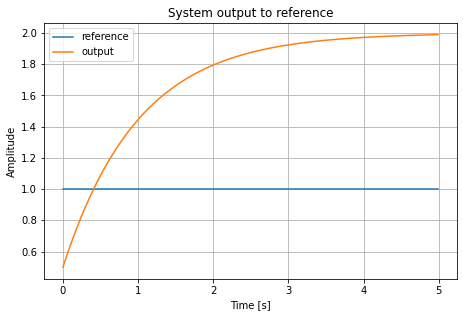

In [ ]:
# Simulação da planta em malha aberta

start = time.process_time()

# Parte 1: configuração da simulação

h = 0.01 # seconds
tend = 5 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

# Parte 2: instanciamento dos blocos
const = Source(name='Source', h=h, amplitude=lambda t:1)
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])

# Parte 3: execução da simulação
r, y = ([],[])
for sim in range(samples):
  source = const.work()
  outPlant = plant.work(source)

  y.append(outPlant)
  r.append(source)

# Parte 4: apresentação dos resultados
PlotArrays(t=t,r=r,y=y)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

Diferente da planta que possui uma dinâmica de primeira ordem, mais a frente nas simulações quatro e cinco será adicionada uma dinâmica desconhecida de segunda ordem com os parâmetros $\omega_n^2=229$ e $2\xi \omega_n = 30$ na forma:

\begin{align}
H(s) = \frac{\omega_n^2}{s+2\xi \omega_n s+ \omega_n^2}  = \frac{229}{s^2+30s+229} \tag{2}
\end{align}

Por fim, o controlador usado será um PI com parâmetros variáveis de acordo com cada experimento e terá a forma:

\begin{align}
G_c(s) = k_1 + \frac{k_2}{s} \tag{3}
\end{align}

O sistema completo terá uma realimentação negativa e obedecerá o seguinte diagrama:

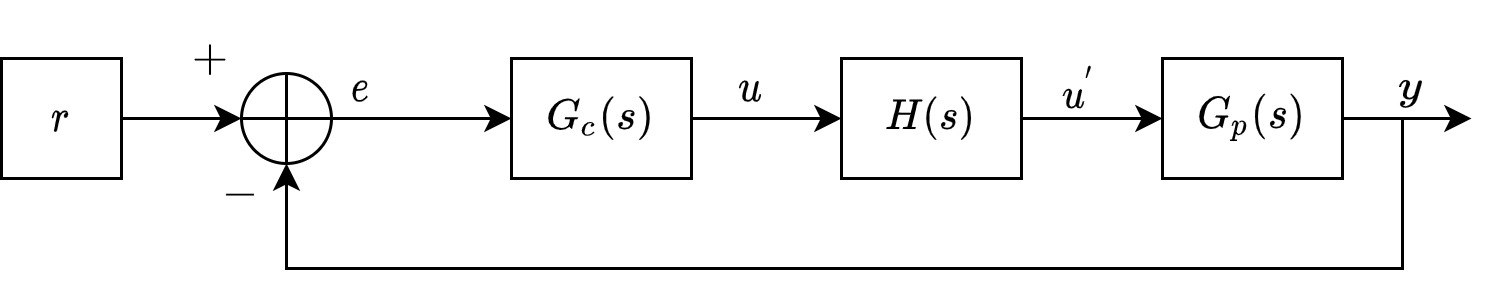

In [11]:
display(Image(filename='images/figura1.jpg'))

OBS: Nas três primeiras simulações a dinâmica não modelada $H(s)$ não estará presente, dessa forma podendo desconsiderar sua existência ou fazer $H(s)=1$.

#### Primeira simulação

Nesta simulação os parâmetros do controlador são $k_1=k_2=1.5$, portanto a função de transferência de malha fechada será:

\begin{align}
G_{MF}(s) = \frac{G_pG_c}{1+G_pG_c} = \frac{num(G_pG_c)}{num(G_pG_c)+den(G_pG_c)} = \frac{3}{s+3} 
\end{align}

Com: $G_pG_c(s) = \frac{3}{s}$.

Como observado na função de transferência de malha fechada o único polo ficou localizado em $p_1=-3$, como esperado no enunciado da simulação. Em termos do tempo de estabilização, este possuirá um valor esperado de $T_{ss,2\%} = 4/p_1 = 1.33 \, s$.

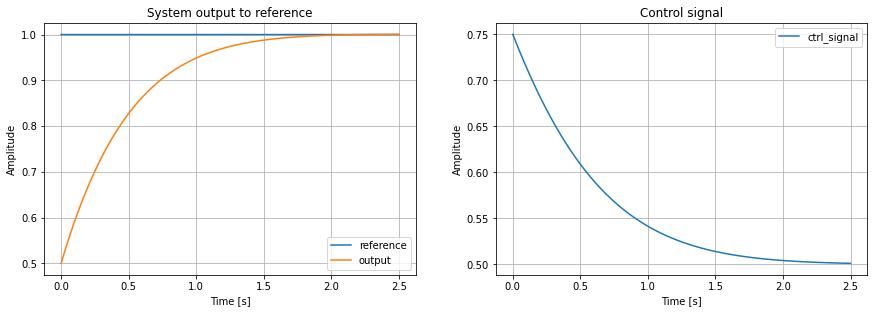

In [ ]:
# Primeira simulação

start = time.process_time()

h = 0.0001 # seconds
tend = 2.5 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:1)
sub = Sum(name='Sum', ports_gains=(1,-1)) 
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])
ctrl = PID(name='PI', h=h, Kp=1.5, Ki=1.5, Kd=0)

r, y, u = ([],[],[])
outPlant = plant.get_out()
for sim in range(samples):
  source = const.work()
  error = sub.work([source, outPlant])
  outCtrl = ctrl.work(error)
  outPlant = plant.work(outCtrl)

  y.append(outPlant)
  r.append(source)
  u.append(outCtrl)

PlotArrays(t=t,r=r,y=y,u=u)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

Os resultados da simulação corroboram com um projeto adequado de controlador, uma vez que o tempo de estabilização esteve dentro do esperando, implicando que o polo de malha fechada desejado de $p_1=-3$ foi de fato alcançado.

O sinal de controle apresentou-se bastante suave, matendo sua continuidade ao longo de toda a simulação.

####  Segunda simulação

Nesta simulação os parâmetros do controlador são $k_1=1.2$ e $k_2=0.6$, portanto a função de transferência de malha fechada será:

\begin{align}
G_{MF}(s) =\frac{2.4s+1.2}{s^2+3.4s+1.2}
\end{align}

Com: $G_pG_c(s) = \frac{2.4s+1.2}{s(s+1)}$.

Assim os polos ficaram localizados em $p_1=-3$ e $p_2=-0.4$ e um zero em $z_1=-0.5$. O polo menor em $-0.4$ irá inserir um comportamento mais lento ao sistema que o polo anterior e o desempenho desejado de apenas um polo em $-3$ não será totalmente obtido.

Como os dois polos são reais e diferentes, este sistema é superamortecido.

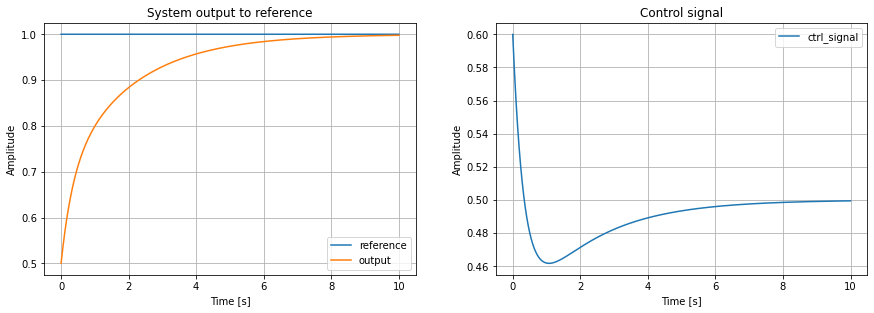

In [ ]:
# Segunda simulação

start = time.process_time()

h = 0.0001 # seconds
tend = 10 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:1)
sub = Sum(name='Sum', ports_gains=(1,-1)) 
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])
ctrl = PID(name='PI', h=h, Kp=1.2, Ki=0.6, Kd=0)

r, y, u = ([],[],[])
outPlant = plant.get_out()
for sim in range(samples):
  source = const.work()
  error = sub.work([source, outPlant])
  outCtrl = ctrl.work(error)
  outPlant = plant.work(outCtrl)

  y.append(outPlant)
  r.append(source)
  u.append(outCtrl)

PlotArrays(t=t,r=r,y=y,u=u)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

Ao comparar os resultados deste projeto com o da primeira simulação, observa-se que este está longe do ideal. Enquanto que a dinâmica desejada requeriria um tempod e estabilização de $1.33 \, s$, este sistema apresentou um tempo bem maior de $5.55 \, s$.

Esse atraso para alcançar o baixo critério de erro em regime se deve ao fato da parcela integrativa do controlador ter sido reduzida. 

Uma vez que a parcela proporcional do controlador se manteve alta, esta ocasionou um sinal de controle de alta amplitude no início.

####  Terceira simulação

Nesta simulação os parâmetros do controlador são $k_1=0.9$ e $k_2=1.4$, portanto a função de transferência de malha fechada será:

\begin{align}
G_{MF}(s) =\frac{1.8s+2.8}{s^2+2.8s+2.8}
\end{align}

Com: $G_pG_c(s) = \frac{1.8s+2.8}{s(s+1)}$.

Assim os polos são complexos $p=-1.4 \pm j0.91$ e um zero em $z_1=-1.55$. O polo menor em $-0.4$ irá inserir um comportamento mais lento ao sistema que o polo anterior.

Como os dois polos são complexos conjugados, este sistema é subamortecido.

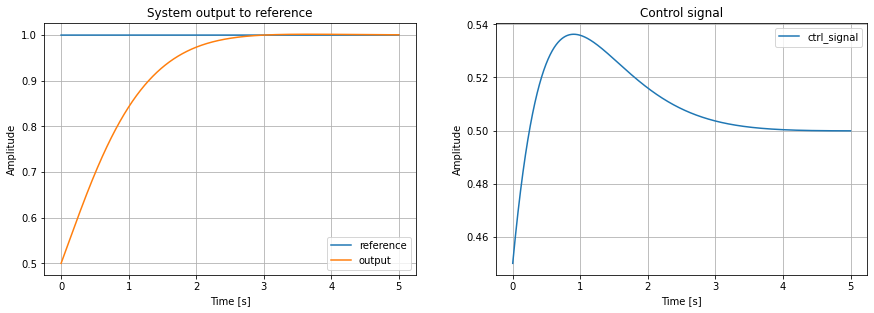

In [ ]:
# Terceira simulação

start = time.process_time()

h = 0.0001 # seconds
tend = 5 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:1)
sub = Sum(name='Sum', ports_gains=(1,-1)) 
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])
ctrl = PID(name='PI', h=h, Kp=0.9, Ki=1.4, Kd=0)

r, y, u = ([],[],[])
outPlant = plant.get_out()
for sim in range(samples):
  source = const.work()
  error = sub.work([source, outPlant])
  outCtrl = ctrl.work(error)
  outPlant = plant.work(outCtrl)
  y.append(outPlant)
  r.append(source)
  u.append(outCtrl)

PlotArrays(t=t,r=r,y=y,u=u)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

Essa simulação apresentou um tempo de estabilização menor que a anterior. Porém ainda não tão ideal quanto a primeira simulação. A resposta também apresentou uma leve ultrapassagem acima do valor de referência, mas foi rapidamente resolvida.

#### Quarta simulação

Nesta simulação os parâmetros do controlador são $k_1=1.2$ e $k_2=0.6$, porém a dinâmica desconhecida $H(s)$ foi adicionada, portanto a função de transferência de malha fechada será:

\begin{align}
G_{MF}(s) =\frac{549s+274.8}{s^4+31s^3+259s^2+778s+274.8}
\end{align}

Com: $G_pG_c(s) = \frac{549s+274.8}{s(s^3+31s^2+259s+229)}$.

Assim os polos são variados $p_{1,2}=6.707 \pm j10.32$, $p_3=-15.2$ e $p_4=-29.2$ e um zero em $z_1=-0.5$. 

Os polos mais afastados ($p_3$ e $p_4$) dos polos dominantes $p_{1,2}$ irão adicionar uma dinâmica bem rápida e com influência apeans nos momentos iniciais da resposta.

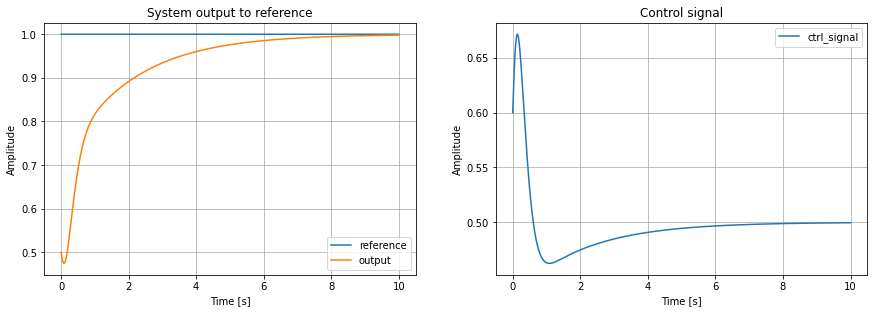

In [ ]:
# Quarta simulação

start = time.process_time()

h = 0.0001 # seconds
tend = 10 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:1)
sub = Sum(name='Sum', ports_gains=(1,-1)) 
#unkDyn = SecondOrderTF(name='2ndTF', h=0.0001, wn=np.sqrt(229), xi=30/2/np.sqrt(229), initial_conditions=(0,0))
unkDyn = TF(name='2ndTF', h=h, initial_conditions=[0,0], numerator=[229], denominator=[1,30,229])
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])
ctrl = PID(name='PI', h=h, Kp=1.2, Ki=0.6, Kd=0)

r, y, u = ([],[],[])
outPlant = plant.get_out()
for sim in range(samples):
  source = const.work()
  error = sub.work([source, outPlant])
  outCtrl = ctrl.work(error)
  outDyn = unkDyn.work(outCtrl)
  outPlant = plant.work(outDyn)
  y.append(outPlant)
  r.append(source)
  u.append(outCtrl)

PlotArrays(t=t,r=r,y=y,u=u)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

De acordo com a simulação o sistema possui um comportamento inicial de fase não-mínima, porém logo se recompõe, influenciado pelo seu sinal de controle que inicialmente possuia comportamento crescente, mas alternou para um comportamento decrescente.

O baixo ganho integrativo do controlador também contribui para que o erro em regime reduza rapidamente.

#### Quinta simulação

Nesta simulação os parâmetros do controlador são $k_1=0.9$ e $k_2=1.4$, porém a dinâmica desconhecida $H(s)$ foi adicionada, portanto a função de transferência de malha fechada será:

\begin{align}
G_{MF}(s) =\frac{412.2s+641.2}{s^4+31s^3+259s^2+641.2s+641.2}
\end{align}

Com: $G_pG_c(s) = \frac{412.2s+641.2}{s(s^3+31s^2+259s+229)}$.

Assim os polos são variados $p_{1,2}=6.74 \pm j10.25$, $p_3=-15.5$ e $p_4=-28.98.2$ e um zero em $z_1=-1.55$. 

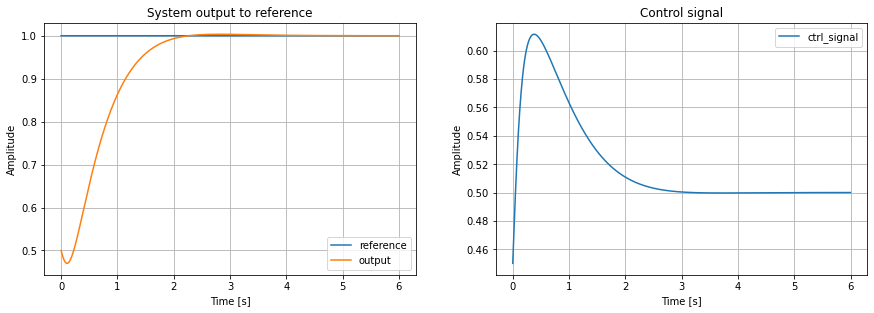

In [ ]:
# Quinta simulação

start = time.process_time()

h = 0.0001 # seconds
tend = 6 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:1)
sub = Sum(name='Sum', ports_gains=(1,-1)) 
#unkDyn = SecondOrderTF(name='2ndTF', h=0.0001, wn=np.sqrt(229), xi=30/2/np.sqrt(229), initial_conditions=(0,0))
unkDyn = TF(name='2ndTF', h=h, initial_conditions=[0,0], numerator=[229], denominator=[1,30,229])
plant = TF(name='Planta', h=h, initial_conditions=[0.5], numerator=[2], denominator=[1,1])
ctrl = PID(name='PI', h=h, Kp=0.9, Ki=1.4, Kd=0)

r, y, u = ([],[],[])
outPlant = plant.get_out()
for sim in range(samples):
  source = const.work()
  error = sub.work([source, outPlant])
  outCtrl = ctrl.work(error)
  outDyn = unkDyn.work(outCtrl)
  outPlant = plant.work(outDyn)
  y.append(outPlant)
  r.append(source)
  u.append(outCtrl)

PlotArrays(t=t,r=r,y=y,u=u)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

Esta simulação ainda apresenta os efeitos da dinâmica desconhecida, com um comportamento de fase não-mínima, mas agora com um tempo de estabilização menor devido ao aumento da parcela integrativa do controlador.

## Segunda parte: controle adaptativo por modelo de referência (MRAC)

As simulações descritas aqui contarão com três modelos distintos de planta. Sendo eles:







- Modelo nominal da planta com $k_p=2$ e $a_p=1$:



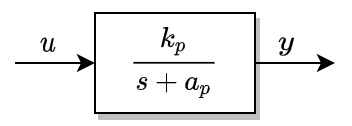

In [12]:
display(Image(filename='images/figura2.jpg'))

- Modelo real da planta nominal com $2\xi \omega_n= 30$ e $\omega_n^2=229$:


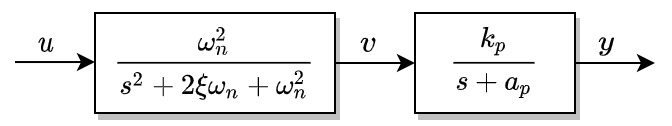

In [13]:
display(Image(filename='images/figura3.jpg'))


- Modelo de referência com $k_m=3$ e $a_m=3$:

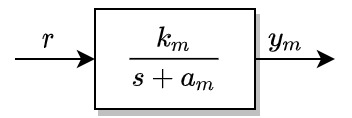

In [14]:
display(Image(filename='images/figura4.jpg'))

Os comentários que podem ser tecidos acerca desses modelos são:

- A planta nominal e o modelo de referência sempre seguirão esse modelo e serão de primeira ordem;
- A dinâmica não modelada também seguirá o mesmo modelo de segunda ordem indicado acima;
- Será utilizado em todas as simulações o método de Euler com passo $h = 100  \mu s$.

Nesse segundo ciclo de simulações será utilizado como base o sistema de **Controle Adaptativo por Modelo de Referência** (MRAC). Seu diagrama de blocos está representado abaixo. 

Como definidos anteriormente, o modelo de referência e da planta (formato nominal e real) serão estáticos. O que diferenciará em alguns momentos é que os parâmetros da planta serão ditos desconhecidos (apesar da planta ser simulada sempre com os parâmetros dados anteriormente), fazendo com que apenas o projeto do controlador seja alterado. 

O modelo do controlador será um do tipo proporcional generalizado com distintos coeficientes proporcionais atuando sobre o valor de referência e o valor de saída, assim resultando na seguinte equação para o sinal de controle $u$:

\begin{align}
u = \theta_{C1}y + \theta_{C2}r
\end{align}

Ao longo das simulações o que será alterado é a forma com que o estimador irá influenciar os parâmetros do controlador.

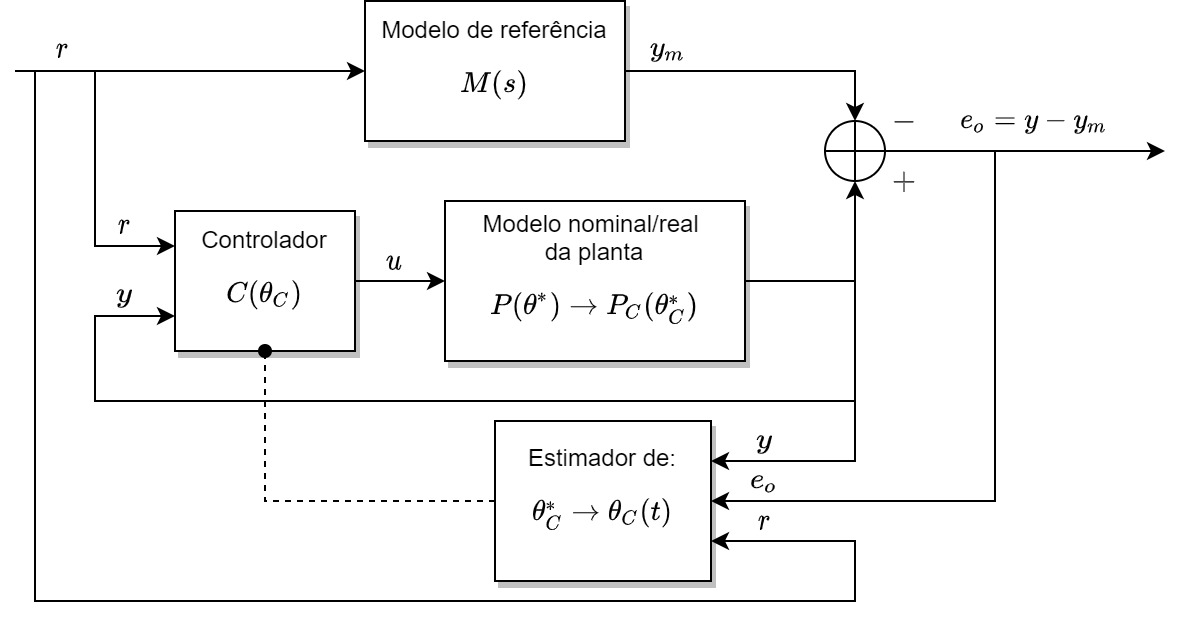

In [15]:
display(Image(filename='images/figura5.jpg'))

Abaixo os dados comuns às plantas descritas anteriormente podem ser carregados

In [16]:
# Execute para armazenar os dados das simulações

km = 3 
am = 3 
kp = 2 
ap = 1 
xi2wn = 30 
wn2 = 229 

Ao longo das simulações dessa parte o único bloco a ser alterado será o estimador e, eventualmente, a referência $r$. Também um ruído senoidal (fonte senoidal) pode ser adicionada à saída da planta. 

Salve essas exceções, os demais blocos permanecerão os mesmos. Para reiniciar os parâmetros desses blocos de uma simulação para a outra será utilizado o método **reset**. Os blocos que terão os parâmetros reiniciados são: a planta nominal, a dinâmica não modelada, o modelo de referência e o controlador adaptativo (esse controlador possui seus parâmetros alterados pelo estimador, por isso necessitando a redefinição).

Vide abaixo a inicialização dos blocos a serem utilizados:

In [17]:
# Basic blocks for simulation

h = 0.0001 # sampling period in seconds commom for all simulation
sub = Sum(name='Subtraction', ports_gains=(1,-1)) # immutable subtraction block
nomPlant = TF(name='NominalPlant', h=h, initial_conditions=[0.5], 
              numerator=[kp], denominator=[1,ap]) # nominal plant
refPlant = TF(name='ReferenceModel', h=h, initial_conditions=[0], 
              numerator=[km], denominator=[1,am]) # reference model
unkDyn = TF(name='2ndTF', h=h, initial_conditions=[0,0], 
            numerator=[wn2], denominator=[1,xi2wn,wn2]) # unknown dynamics
ctrl = AdaptiveController(name='AdaptiveController', 
                          ports_gains = [(ap-am)/kp, km/kp]) # adaptive controller

Como o formato de algumas simulações se repetem, abaixo serão criadas algumas funções para encapsular essas simulações básicas.

In [29]:
# simulação apenas com o modelo nominal da planta
def sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator):
    samples = np.int32(np.round(tend/h))
    t = np.arange(samples)*h
    r, y, ym, u = ([],[],[],[])
    outPlant = nomPlant.get_out()
    outRefPlant = refPlant.get_out() 
    for sim in range(samples):
      source = const.work()
      error = sub.work([outPlant, outRefPlant])
      outCtrl = ctrl.work([outPlant, source])
      outPlant = nomPlant.work(outCtrl)
      outRefPlant = refPlant.work(source)
      ctrl.set_parameters(estimator.work([outPlant,error,source]))

      y.append(outPlant)
      ym.append(outRefPlant)
      r.append(source)
      u.append(outCtrl)

    PlotArrays(t=t,r=r,y=y,u=u,ym=ym)
    
# simulação com dinâmica não modelada inserida tornando o modelo real da planta
def sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator):
    samples = np.int32(np.round(tend/h))
    t = np.arange(samples)*h
    r, y, ym, u = ([],[],[],[])
    outPlant = nomPlant.get_out()
    outRefPlant = refPlant.get_out() 
    for sim in range(samples):
      source = const.work()
      error = sub.work([outPlant, outRefPlant])
      outCtrl = ctrl.work([outPlant, source])
      signalCtrl= unkDyn.work(outCtrl)
      outPlant = nomPlant.work(signalCtrl)
      outRefPlant = refPlant.work(source)
      ctrl.set_parameters(estimator.work([outPlant,error,source]))

      y.append(outPlant)
      ym.append(outRefPlant)
      r.append(source)
      u.append(outCtrl)
    PlotArrays(t=t,r=r,y=y,u=u,ym=ym)
# simulação com ruído senoidal aditivo na saída do modelo real da planta
def sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator):
    samples = np.int32(np.round(tend/h))
    t = np.arange(samples)*h
    r, y, ym, u = ([],[],[],[])
    outPlant = nomPlant.get_out()
    outRefPlant = refPlant.get_out() 
    for sim in range(samples):
      source = const.work()
      error = sub.work([outPlant, outRefPlant])
      outCtrl = ctrl.work([outPlant, source])
      signalCtrl= unkDyn.work(outCtrl)
      outPlant = nomPlant.work(signalCtrl) + noise.work()
      outRefPlant = refPlant.work(source)
      ctrl.set_parameters(estimator.work([outPlant,error,source]))

      y.append(outPlant)
      ym.append(outRefPlant)
      r.append(source)
      u.append(outCtrl)

    PlotArrays(t=t,r=r,y=y,u=u,ym=ym)

### Simulações de Rohrs

#### Sexta simulação

In [ ]:
# Sexta simulação

start = time.process_time()

tend = 3 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [(ap-am)/kp, km/kp])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [0,0])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Sétima simulação

In [ ]:
# Sétima simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Oitava simulação

In [ ]:
# Oitava simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:4.3)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
unkDyn.reset(initial_conditions=[0,0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = [-0.65, 1.14], 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Nona simulação

In [ ]:
# Nona simulação

start = time.process_time()

tend = 20 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:0.3+1.85*np.sin(16.1*t))
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
unkDyn.reset(initial_conditions=[0,0])
ctrl.reset(ports_gains = [-0.65, 1.14])

estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima simulação

In [ ]:
# Décima simulação

start = time.process_time()

tend = 80 # seconds
samples = np.int32(np.round(tend/h))
t = np.arange(samples)*h

const = Source(name='Source', h=h, amplitude=lambda t:2)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.5*np.sin(16.1*t))
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
unkDyn.reset(initial_conditions=[0,0])
ctrl.reset(ports_gains = [-0.65, 1.14])

estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

r, y, ym, u = ([],[],[],[])
outPlant = nomPlant.get_out()
outRefPlant = refPlant.get_out() 
count = 0
for sim in range(samples):
  source = const.work()
  error = sub.work([outPlant, outRefPlant])
  outCtrl = ctrl.work([outPlant, source])
  signalCtrl= unkDyn.work(outCtrl)
  outPlant = nomPlant.work(signalCtrl) + noise.work()
  outRefPlant = refPlant.work(source)
  ctrl.set_parameters(estimator.work([outPlant,error,source]))
  count+=1
  if(count==10):
    y.append(outPlant)
    ym.append(outRefPlant)
    r.append(source)
    u.append(outCtrl)
    count=0

PlotArrays(t=t[0:-1:10],r=r,y=y,u=u,ym=ym)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima primeira simulação

In [ ]:
# Décima primeira simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1+0.1*np.sin(1.5*t))
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])

estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima segunda simulação

In [ ]:
# Décima segunda simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1+0.1*np.sin(1.5*t))
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
unkDyn.reset(initial_conditions=[0,0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima terceira simulação

In [ ]:
# Décima terceira simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1+0.1*np.sin(1.5*t))
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
unkDyn.reset(initial_conditions=[0,0])
ctrl.reset(ports_gains = [-0.65, 1.14])

estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law='integral', 
                          adaptive_gains = [1,1])

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima quarta simulação

In [ ]:
# Décima quarta simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='dead_zone', 
                          adaptive_gains = [1,1],
                          dead_zone = 0.1)

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima quinta simulação

In [ ]:
# Décima quinta simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])

estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='dead_zone', 
                          adaptive_gains = [1,1],
                          dead_zone = 0.1)

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima sexta simulação

In [ ]:
# Décima sexta simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='dead_zone', 
                          adaptive_gains = [1,1],
                          dead_zone = 0.1)

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima sétima simulação

In [ ]:
# Décima sétima simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='limitation', 
                          adaptive_gains = [1,1],
                          limiter = 0.5)

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima oitava simulação

In [ ]:
# Décima oitava simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='limitation', 
                          adaptive_gains = [1,1],
                          limiter = 0.5)

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Décima nona simulação

In [ ]:
# Décima nona simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='limitation', 
                          adaptive_gains = [1,1],
                      limiter=miter = 0.5)

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima simulação

In [ ]:
# Vigésima simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='normalization', 
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima primeira simulação

In [ ]:
# Vigésima primeira simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='normalization', 
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima segunda simulação

In [ ]:
# Vigésima segunda simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='normalization', 
                          adaptive_gains = [1,1])

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima terceira simulação

In [ ]:
# Vigésima terceira simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification', 
                          forgetfulness_factor = 0.2,
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima quarta simulação

In [ ]:
# Vigésima quarta simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification', 
                          forgetfulness_factor = 0.2,
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima quinta simulação

In [ ]:
# Vigésima quinta simulação

start = time.process_time()

tend = 10 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification', 
                          forgetfulness_factor = 0.2,
                          adaptive_gains = [1,1])

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima sexta simulação

In [ ]:
# Vigésima sexta simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification_with_normalization',
                          limiter = 0.5,
                          forgetfulness_factor = 0.2,
                          delta0=0.5, delta1=0.1, m0=2,
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima sétima simulação

In [ ]:
# Vigésima sétima simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification_with_normalization',
                          limiter = 0.5,
                          forgetfulness_factor = 0.2,
                          delta0=0.5, delta1=0.1, m0=2,
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima oitava simulação

In [ ]:
# Vigésima oitava simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='sigma_modification_with_normalization',
                          limiter = 0.5,
                          forgetfulness_factor = 0.2,
                          delta0=0.5, delta1=0.1, m0=2,
                          adaptive_gains = [1,1])

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Vigésima nona simulação

In [ ]:
# Vigésima nona simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='projection',
                          limiter = 1.5,
                          adaptive_gains = [1,1])

sim_nominal(h, tend, const, nomPlant, refPlant, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Trigésima simulação

In [ ]:
# Trigésima simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='projection',
                          limiter = 1.5,
                          adaptive_gains = [1,1])

sim_real(h, tend, const, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')

#### Trigésima primeira simulação

In [ ]:
# Trigésima primeira simulação

start = time.process_time()

tend = 5 # seconds
const = Source(name='Source', h=h, amplitude=lambda t:1)
noise = Source(name='NoiseSource', h=h, amplitude=lambda t:0.1*np.sin(16.1*t))
unkDyn.reset(initial_conditions=[0,0])
nomPlant.reset(initial_conditions=[0.5])
refPlant.reset(initial_conditions=[0])
ctrl.reset(ports_gains = [-0.65, 1.14])
estimator = EstimatorMRAC(name='Estimator', 
                          actual_controller_gains = ctrl.get_parameters(), 
                          adaptation_law ='projection',
                          limiter = 1.5,
                          adaptive_gains = [1,1])

sim_real_noisy(h, tend, const, noise, nomPlant, refPlant, unkDyn, ctrl, estimator)
print('Duration: ' + str(time.process_time()-start) + ' seconds')